In [1]:
#Import wymaganych bibliotek
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('city_temperature.csv', index_col=0)

Miasto, które wybierzemy do analizy to Warszawa

In [3]:
df = df[df['City'] == 'Warsaw']

Przyjrzyjmy się pierwszym 5 wierszom naszego zbioru

In [4]:
df.head()

,Country,State,City,Month,Day,Year,AvgTemperature
Region,,,,,,,
Europe,Poland,NaN,Warsaw,1,1,1995,35.4
Europe,Poland,NaN,Warsaw,1,2,1995,30.5
Europe,Poland,NaN,Warsaw,1,3,1995,27.2
Europe,Poland,NaN,Warsaw,1,4,1995,22.9
Europe,Poland,NaN,Warsaw,1,5,1995,18.7


Zacznijmy od skonstruowania pełnej daty. W tym celu połączymy kolumny month, day i year.

In [5]:
df['data'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)

Następnie kolumnę data ustawmy jako nowy indeks i zmieńmy jej typ na datetime

In [6]:
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

Na koniec ze zmiennej DataFrame stworzymy zmienną Series wyciągając tylko interesującą nas kolumnę czyli AvgTemperature

In [7]:
df_series = df['AvgTemperature']
df_series

data
1995-01-01    35.4
1995-01-02    30.5
1995-01-03    27.2
1995-01-04    22.9
1995-01-05    18.7
              ... 
2020-05-09    57.9
2020-05-10    63.5
2020-05-11    62.3
2020-05-12    42.8
2020-05-13    39.8
Name: AvgTemperature, Length: 9266, dtype: float64

Temperatury na pierwszy rzut oka wydają się bardzo wysokie. Są one jednak podane w stopniach Farenheita. Aby były one dla nas przyjaźniejsze zamienimy je na stopnie Celsjusza i zaokraglimy do jednego miejsca po przecinku:

In [8]:
df = (df_series - 32)/1.8
df = df.round(1)
df

data
1995-01-01     1.9
1995-01-02    -0.8
1995-01-03    -2.7
1995-01-04    -5.1
1995-01-05    -7.4
              ... 
2020-05-09    14.4
2020-05-10    17.5
2020-05-11    16.8
2020-05-12     6.0
2020-05-13     4.3
Name: AvgTemperature, Length: 9266, dtype: float64

Sprawdźmy, czy w zbiorze znajdują się jakieś wartości nieznane (NaN):

In [9]:
df.isna().sum()

0

Brak

W ramach weryfikacji sprawdźmy również, czy jakiś indeks się powtarza:

In [10]:
df.index.value_counts()

2015-12-30    2
1995-01-01    1
2011-12-03    1
2011-11-27    1
2011-11-28    1
             ..
2003-06-17    1
2003-06-18    1
2003-06-19    1
2003-06-20    1
2020-05-13    1
Name: data, Length: 9265, dtype: int64

Dla 30 grudnia odnotowujemy 2 indeksy. Zweryfikujmy co dzieje się w grudniu 2015 roku:

In [11]:
df['2015-12-30']

data
2015-12-30    -4.1
2015-12-30   -72.8
Name: AvgTemperature, dtype: float64

Temperatura -72.8 stopnia bez dwóch zdań jest błędem pomiarowym. Usuwamy ten wiersz:

In [12]:
df = df[~df.index.duplicated(keep='first')]

In [13]:
df[df.index == '2015-12-30']

data
2015-12-30   -4.1
Name: AvgTemperature, dtype: float64

Pozostała nam tylko jedna temperatura, ta poprawna. W ramach dalszej weryfikacji poprawności zbioru zbadamy obecność wartości odstających (outlierów) za pomocą metryki z-score. Określa ona jak daleko nasz wartości znajdują się od standardowych wartości w tym zbiorze. Im większy z-score tym bardziej można podejrzewać, że dana próbka może być outlierem

In [14]:
from scipy.stats import zscore

df_zscore = zscore(df)

Sprawdźmy histogram dla wartości z-score. Zobaczymy tam w jakiejś skali mieszczą się z-score dla naszego szeregu:

<AxesSubplot:>

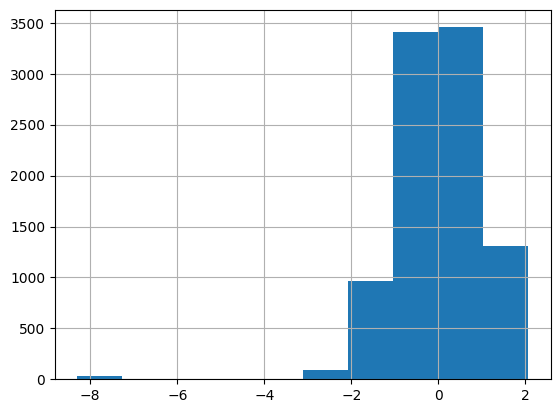

In [15]:
df_zscore.hist()

Większość próbek zawiera się w przedziałach od -3 do 2. Jest to standardowy zakres, który nie powinien budzić naszych obaw. Sprawdźmy, co to są za próbki, które mieszczą się w wartościach poniżej -4.

In [16]:
df[df_zscore < -4]

data
1998-12-24   -72.8
1998-12-25   -72.8
1998-12-30   -72.8
1998-12-31   -72.8
1999-01-10   -72.8
2002-06-18   -72.8
2002-06-19   -72.8
2002-06-20   -72.8
2002-06-21   -72.8
2007-08-28   -72.8
2008-08-18   -72.8
2008-09-24   -72.8
2009-04-09   -72.8
2014-02-06   -72.8
2015-12-31   -72.8
2016-03-10   -72.8
2016-05-05   -72.8
2016-09-21   -72.8
2016-11-11   -72.8
2018-01-04   -72.8
2018-11-14   -72.8
2018-11-15   -72.8
2018-11-17   -72.8
2019-01-23   -72.8
2019-04-24   -72.8
2019-05-16   -72.8
2019-05-17   -72.8
2019-05-18   -72.8
2019-05-19   -72.8
Name: AvgTemperature, dtype: float64

Widzimy wyraźnie, że jest to ta sama wartość, którą usuwaliśmy już wyżej. Jest to zatem błąd w pomiarach. Tym samym każdą z tych wartości usuniemy, a puste pola uzupełnimy wartości 'ffill'' czyli wartością poprzednią. Tym samym jeśli informacja z np. 15 maja zostanie usunięta to za pomocą frontfill zostanie ona uzupełniona wartością z 14 maja. Jest to bezpieczny sposób uzupełniania informacja, gdyż można zakładać, że temperatura w sąsiadujących dniach jest zbliżona do siebie i dokonując takiego uzupełnienia nie przekłamujemy znacząco rzeczywistej informacji.

In [17]:
maska = df[df_zscore < -4].index
df[maska] = np.NaN
df = df.fillna(method = 'ffill')

Nasz zbiór został sprawdzony pod wzlędem braków i outlierów. Możemy przejść do dalszej analizy. 
Na początek znacząco zmniejszymy nasz zbiór robiąc resampling miesięczny, czyli dane dzienne zamienimy na miesięczne w ten sposób, że weźmiemy średnią temperaturę ze stycznia, następnie średnią temperaturę z lutego itd.

In [18]:
df = df.resample('MS').mean()

Następnie dokonamy podziału zbioru na dwa: treningowy oraz testowy. Do treningowego użyte zostaną lata od 1995 do 2017, a na zbiór testowy przeznaczymy ostatnie dwa i pół roku

In [19]:
df_train = df[df.index < '2017-12-31']
df_test = df[df.index > '2017-12-31']

Przebieg szeregu treningowego:

Text(0.5, 1.0, 'Przebieg szeregu treningowego')

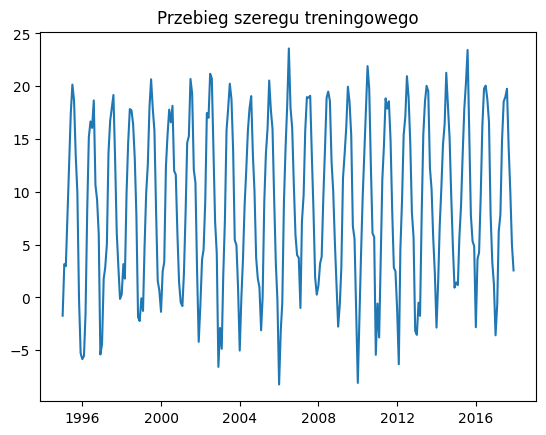

In [20]:
import matplotlib.pyplot as plt
plt.plot(df_train)
plt.title('Przebieg szeregu treningowego')

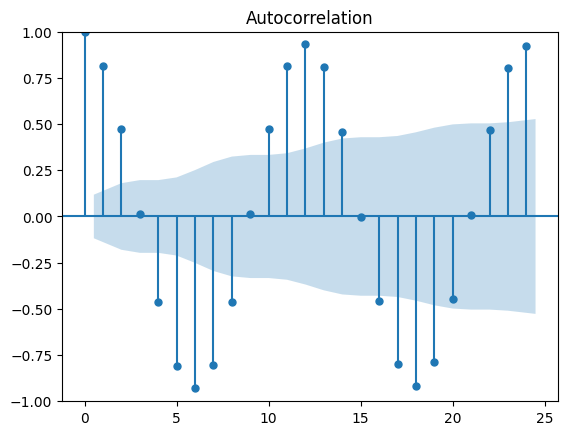

In [21]:
#Wykresy pacf i acf dla surowych danych:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_train.values, lags = 24, adjusted=True)
plt.show()

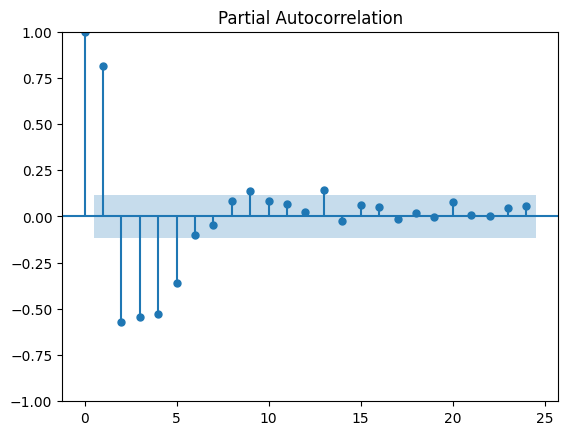

In [22]:
plot_pacf(df_train.values, lags = 24, method='ywm')
plt.show()

Zbadanie stancjonarności surowego szeregu

In [23]:
from statsmodels.tsa.stattools import adfuller

adfuller(df_train.values)

(-2.7465661442249094,
 0.06632105642527673,
 12,
 263,
 {'1%': -3.4554613060274972,
  '5%': -2.8725931472675046,
  '10%': -2.5726600403359887},
 1148.1674497426227)

Wartość p_value == 0.07 nie jest mniejsza niż 0.05 więc nie możemy odrzucić hipotezy zerowej. Tym samym stwierdzamy, że szereg jest niestacjonarny.

Zróżnicowanie szeregu:

In [24]:
df_train_diff = df_train.diff()[1:]
df_test_diff = df_test.diff()[1:]

Przebieg szeregu zróżnicowanego:

Text(0.5, 1.0, 'Przebieg szeregu zróżnicowanego treningowego')

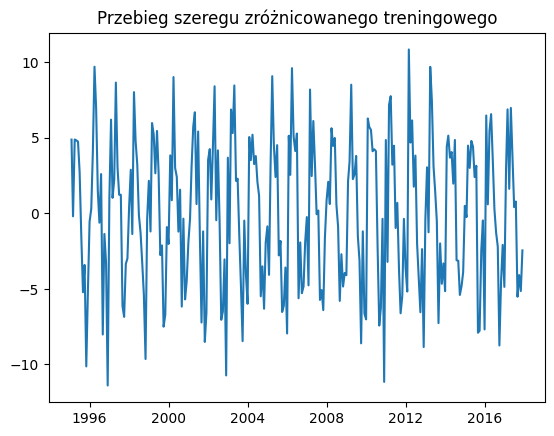

In [25]:
plt.plot(df_train_diff)
plt.title('Przebieg szeregu zróżnicowanego treningowego')

Wykresy pacf i acf dla szeregu zróżnicowanego

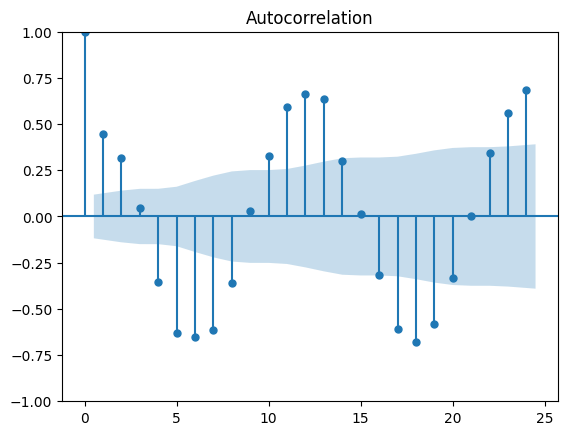

In [26]:
plot_acf(df_train_diff.values, lags = 24, adjusted=True)
plt.show()

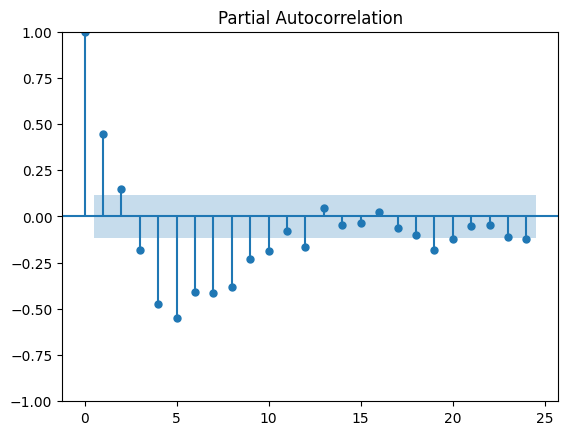

In [27]:
plot_pacf(df_train_diff.values, lags = 24)
plt.show()

Ponowne wykonanie testu na stacjonarność danych:

In [28]:
adfuller(df_train_diff.values)

(-12.100431297312973,
 2.024304888263905e-22,
 11,
 263,
 {'1%': -3.4554613060274972,
  '5%': -2.8725931472675046,
  '10%': -2.5726600403359887},
 1150.386932079865)

Wartość p-value spadła do bardzo małej wartości. Oznacza to, że tym razem otrzymany szereg jest szeregiem stacjonarnym.

Dalej zajmiemy się modelem ARMA używając zróżnicowanego zbioru. Postaramy się dobrać do niego parametry za pomocą kryteriów informacyjnych.

In [29]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')


df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 6
max_q = 6

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(df_train_diff, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [30]:
df.sort_values('AIC').head(5)

,p,q,AIC,BIC,HQIC
16,2,4,1206.474634,1235.408802,1218.086745
15,2,3,1208.549538,1233.866936,1218.710135
23,3,5,1211.432105,1247.599816,1225.947245
21,3,3,1212.036521,1240.970690,1223.648633
28,4,4,1212.548623,1248.716334,1227.063762


Najlepszymi parametrami okazuje się p = 2 oraz q = 4. Tych wartości użyjemy do estymacji parametrów modelu:

In [31]:
model = ARIMA(df_train_diff, order=(2, 0, 4))
model_fit = model.fit()

In [32]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         AvgTemperature   No. Observations:                  275
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -595.237
Date:                Sun, 05 Feb 2023   AIC                           1206.475
Time:                        10:49:14   BIC                           1235.409
Sample:                    02-01-1995   HQIC                          1218.087
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.002      3.018      0.003       0.002       0.010
ar.L1          1.7322      0.000   5040.440      0.000       1.731       1.733
ar.L2         -1.0000   6.81e-05  -1.47e+04      0.0

Aby zmierzyć dopasowanie modelu najpierw sprawdźmy jak dopasował się on do danych treningowych za pomocą wykresu:

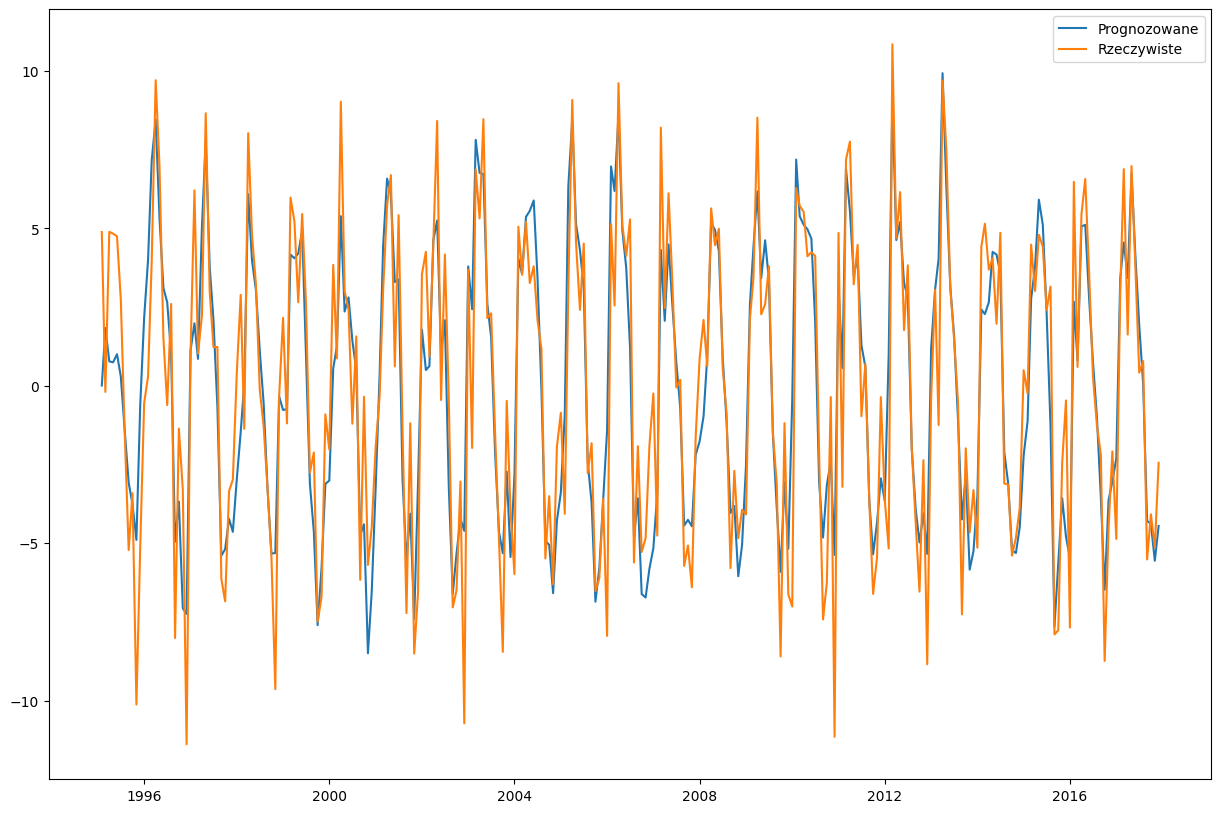

In [33]:
plt.figure(figsize=(15,10))
prognozowane_train = model_fit.predict()
plt.plot(prognozowane_train, label = 'Prognozowane')
plt.plot(df_train_diff, label = 'Rzeczywiste')
plt.legend()
plt.show()

Można zauważyć, że wartość niebieskie (prognozowane) mocno pokrywają się z wartościami rzeczywistymi. Oceńmy teraz dopasowanie do zbioru testowego:

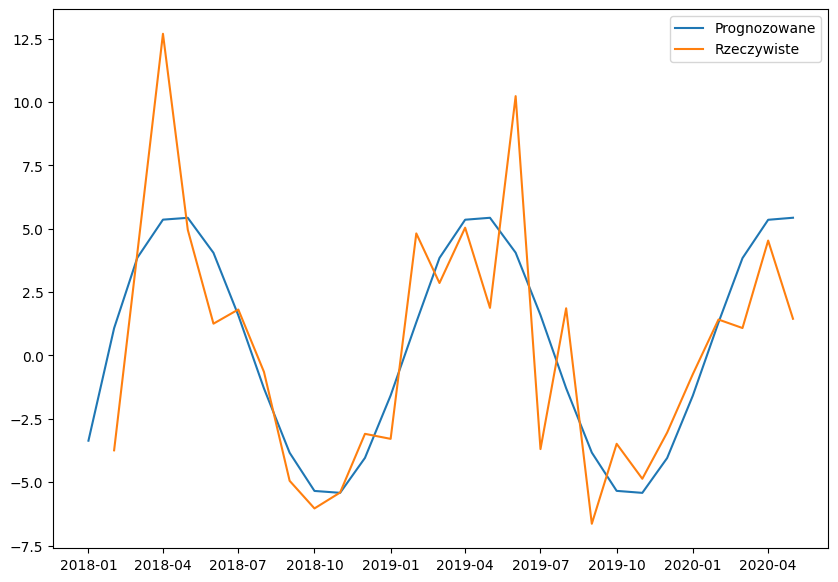

In [34]:
plt.figure(figsize=(10,7))
prognozowane_test = model_fit.forecast(df_test.shape[0])
plt.plot(prognozowane_test, label = 'Prognozowane')
plt.plot(df_test_diff, label = 'Rzeczywiste')
plt.legend()
plt.show()

Wydaje się, że model ARMA w miare dobrze odwzorował wartości prognozowane. Za pomocą metryki mean_absolute_percentage_error ocenimy dopasowanie modelu na zbiorze testowym oraz treningowym. 

In [35]:
from sklearn.metrics import mean_absolute_percentage_error

In [36]:
print('Błąd MAPE prognozy dla zbioru treningowego:', mean_absolute_percentage_error(df_train_diff, prognozowane_train))
print('Błąd MAPE prognozy dla zbioru testowego:', mean_absolute_percentage_error(df_test_diff, prognozowane_test[1:]))

Błąd MAPE prognozy dla zbioru treningowego: 1.0391542276373276
Błąd MAPE prognozy dla zbioru testowego: 0.7643958683120465


Niższy błąd na zbiorze testowym (niż na treningowym) nie jest częstym przypadkiem. Przy klasycznych modelach uczenia maszynowego bardzo rzadko zdarza się taka sytuacja. Znacznie częsciej model notuje lepsze metryki na zbiorze, na którym się uczył. W naszej sytuacji jednak wynik jest inny, jest to oczywiście sytuacja dopuszczalna jednak nie zdarzająca się zbyt często. Błąd MAPE w okolicy 1 oznacza, że nasze wartości różnią się średnio o 1% w stosunku do wartośći rzeczywistych. Jest to więc bardzo mały błąd.


In [37]:
resid = model_fit.resid
params = model_fit.params

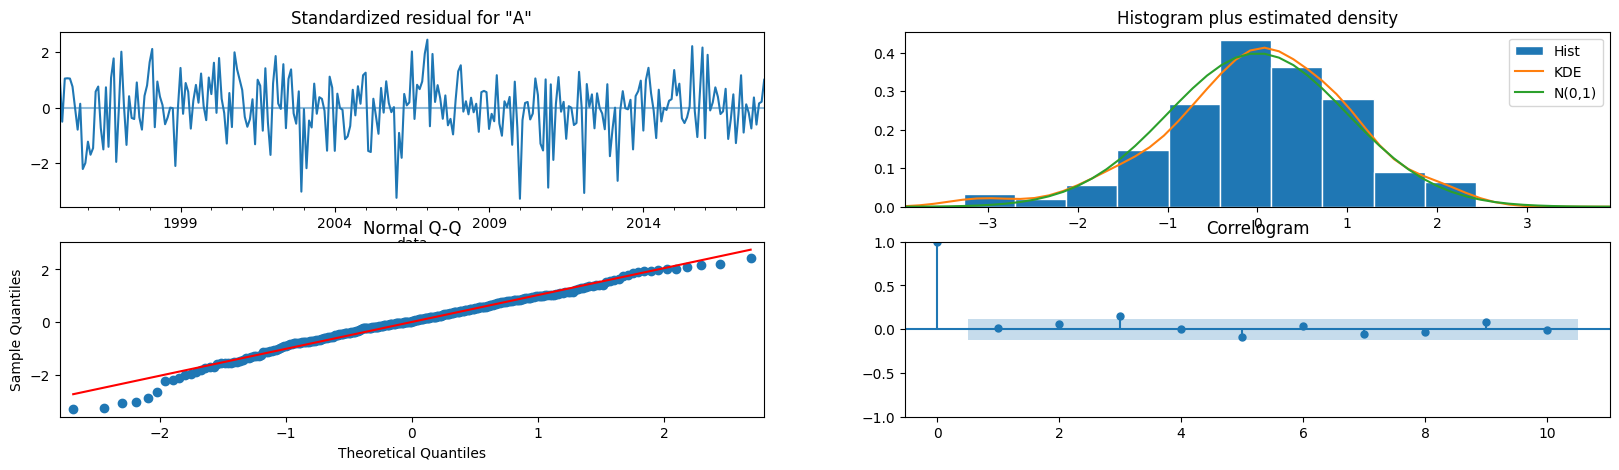

In [38]:
model_fit.plot_diagnostics(0,figsize=(20,5))
plt.show()

Wartości resztowe spełniają założenia rozkładu normalnego. Patrząc na histogram zauważyć możemy rozkład Gaussowski. Aby zbudowany model można uznać za poprawny wartość reszt nie powinny być ze sobą skorelowane: jak widzimy na Correlogramie warunek ten jest spełniony. Sprawdzimy jeszcze testem ARCH, czy zachowana jest wariancja w resztkach:

In [39]:
from statsmodels.stats.diagnostic import het_arch
het_arch(resid)

(17.09182422565207,
 0.07235667701108692,
 1.7511820010596209,
 0.07008110198585374)

p_value na poziomie 0.07. Jest to wartość lekko powyżej 0.05 co oznacza, że stałość wariancji nie jest zachowana. 

Podsumowując: Model w miare dobrze dopasował się do danych i potrafił je odwzorować. Oprócz dobrego dopasowania do danych potrafił również sensownie zapropgnozować różnicę w pogodzie na kolejne 2.5 roku. Oznacza to, że dzięki temu modelowi możemy ze znacznym prawdopodobieństwem przeiwydiwać średnią pogodę na kolejne lata. Warto jednak zastrzeć, że prognozowanie takiej pogody raczej nie powinno być zbytnio ciężkie i najprostsze przepisywanie wartości sprzed 12 miesięcy również okazać by się mogło w miare dokładne. Mimo wszystko model statystyczny ARIMA jest ciekawym algorytmem do modelowania szeregów czasowych. Poza standardowym i podstawowym modelem ARIMA używane są również jego rozserzenia jak:
- SARIMA - model ARIMA z dołożoną sezonowością do lepszego prognozowania danych z wyraźną sezonowością
- SARIMAX - X (od eXogenous [dane zewętrzne]), model ARIMA z sezonowością i uwzględnieniem danych zewnętrznych. Czyli poza jedną modelowaną zmienną mozemy pod uwagę wziąć inne cechy, które mogą pomóc kształtować prognozy.

Kolejną cechą modelów statystycznych, którą warto odnotować, jest stałość obliczeń. W przeciwieństwie do modeli uczenia głębokiego, czy niektórych modeli uczenia maszynowego (których również można używać do prognozowania), dopasowanie modelu po każdym treningu będzie takie samo.  